In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
DATAPATH = r"C:\Users\yuvfr\proj_university\swedish-leaf-dataset"

In [3]:
# paths = [f"leaf{i}.zip" for i in range(1,16)]
# for leaf_path in paths:
#     path_to_zip_file = os.path.join(DATAPATH, leaf_path)
#     path_to_extract = os.path.join(DATAPATH, leaf_path[:-4])
#     print(leaf_path)
#     with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#         zip_ref.extractall(path_to_extract)

In [4]:
def load_image(filename, height=224, width=224):
    img = cv.imread(filename, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (height, width))
    return img

In [5]:
data_dict = dict()
classes = [f'leaf{i}' for i in range(1,16)]

for i, leaf in enumerate(classes):
    
    leaf_path = os.path.join(DATAPATH,leaf)
    print(f"load {leaf}")
    leaf_imgs_list = []
    
    for img_fname in os.listdir(leaf_path):
        leaf_imgs_list.append(load_image(os.path.join(leaf_path, img_fname)))
            
            
    data_dict[leaf] = {'data':np.stack(leaf_imgs_list), 'label':np.repeat(i, len(leaf_imgs_list)).reshape(-1,1)}
    
    print(f"{len(leaf_imgs_list)} images","\n")

load leaf1
75 images 

load leaf2
75 images 

load leaf3
75 images 

load leaf4
75 images 

load leaf5
75 images 

load leaf6
75 images 

load leaf7
75 images 

load leaf8
75 images 

load leaf9
75 images 

load leaf10
75 images 

load leaf11
75 images 

load leaf12
75 images 

load leaf13
75 images 

load leaf14
75 images 

load leaf15
75 images 



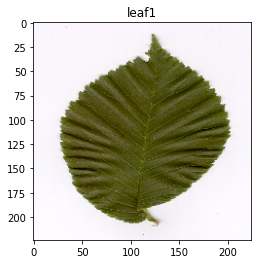

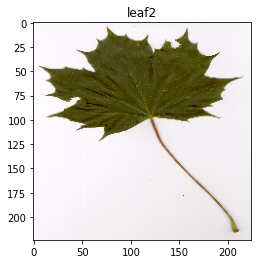

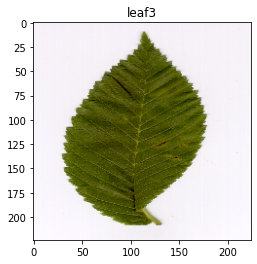

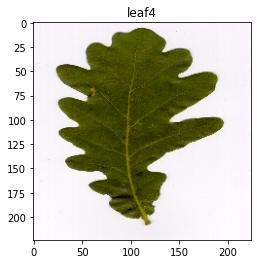

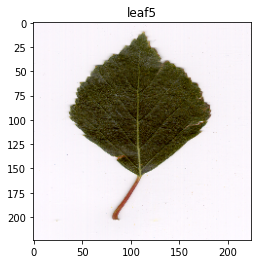

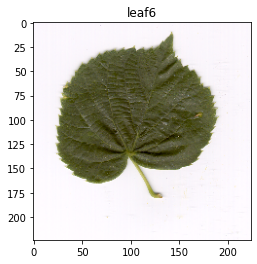

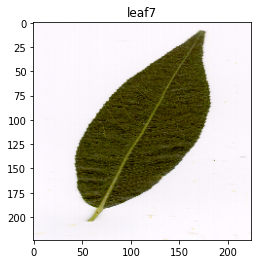

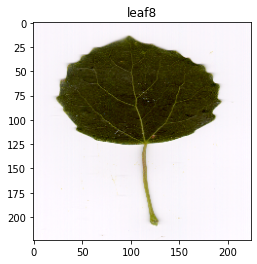

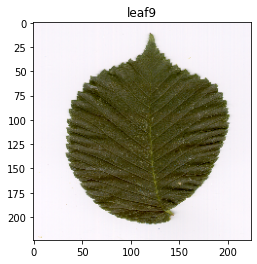

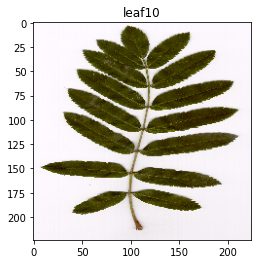

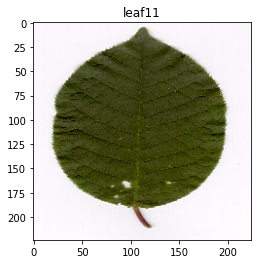

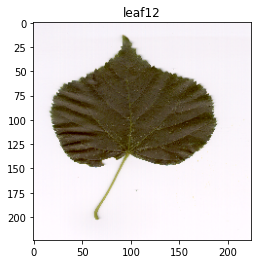

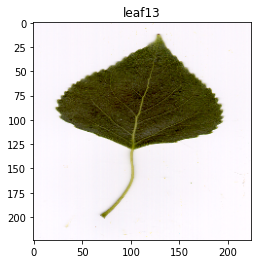

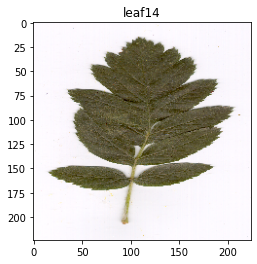

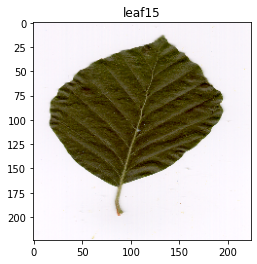

In [77]:
for k in data_dict.keys():
    plt.title(k)
    plt.imshow(data_dict[k]['data'][np.random.randint(low=0,high=75)])
    plt.show()

In [23]:
X_train_list = []
y_train_list = []
# X_val_list = []
# y_val_list = []
X_test_list = []
y_test_list = []

# we want to create train and test sets that are class-balanced and also have similar distribution.
for k in data_dict.keys():
    flat_imgs = data_dict[k]['data'].reshape(len(data_dict[k]['data']),-1)
    X_train, X_test, y_train, y_test = train_test_split(
        flat_imgs, data_dict[k]['label'], test_size=0.1, random_state=42)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_train, y_train, test_size=0.1, random_state=42)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
#     X_val_list.append(X_val)
#     y_val_list.append(y_val)



In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = [
    np.vstack(lst) for lst in [X_train_list, y_train_list, X_val_list, y_val_list, X_test_list, y_test_list]]
[arr.shape for arr in [X_train, y_train, X_val, y_val, X_test, y_test]]

In [26]:
X_train, y_train, X_test, y_test = [
    np.vstack(lst) for lst in [X_train_list, y_train_list, X_test_list, y_test_list]]
[arr.shape for arr in [X_train, y_train, X_val, y_val, X_test, y_test]]

[(1005, 150528), (1005, 1), (90, 512), (90, 1), (120, 150528), (120, 1)]

In [27]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=512)), 
                 ('log_reg', LogisticRegression(max_iter=10_000))])
# scaler = StandardScaler()
# scaler.fit(X_train)
# pca = PCA(n_components=512)
# pca.fit(scaler.transform(X_train))

array([  8,  19,  43,  98, 224])

In [53]:
from sklearn.model_selection import GridSearchCV

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()


log_reg = LogisticRegression(max_iter=10000)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("log_reg", log_reg)])

param_grid = {
    "pca__n_components": np.ceil(np.logspace(start=3, stop=np.log2(224),base=2, num=5)).astype(int),
    "log_reg__C": np.logspace(start=-4, stop=4, base=10, num=5),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train.reshape(-1,))
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.899):
{'log_reg__C': 0.01, 'pca__n_components': 98}


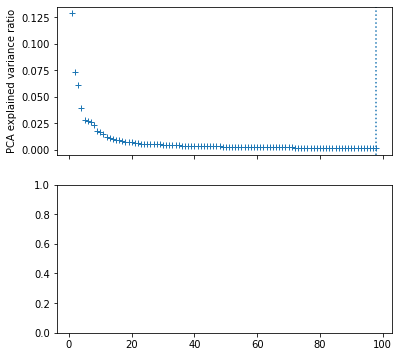

In [60]:

# Plot the PCA spectrum

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, search.best_estimator_['pca'].n_components + 1), 
    search.best_estimator_['pca'].explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)


In [61]:
search.

0.8985074626865671

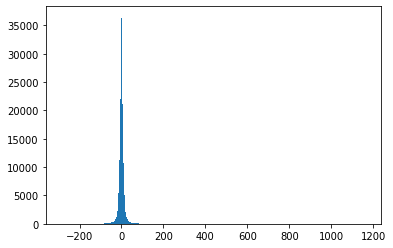

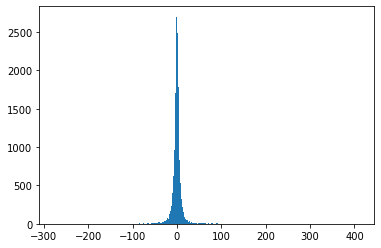

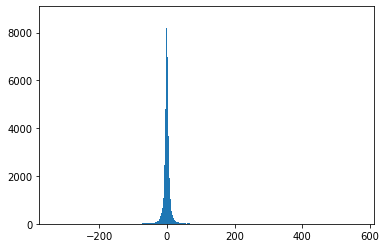

In [13]:
for x_set in [X_train, X_val, X_test]:
    plt.hist(x_set.reshape(-1,), bins=1000)
    plt.show()

In [14]:


reg = LogisticRegression(max_iter=10_000)
reg.fit(X_train,y_train.reshape(-1,))

cv_results = cross_val_score(reg, X_train, y_train.reshape(-1,), cv=5, scoring="accuracy")
# TODO: estimate CrossValidation with another metric ROC for multiclass classification
# TODO: if decide to aumentation the data, estimate the same for vanilla CNN
# TODO: transfer learning

In [ ]:
cv_results = cross_validate(pipe, X_train, y=y_train.reshape(-1,), )

In [15]:
cv_results.mean()

0.8938271604938273

In [16]:
val_preds = reg.predict(X_val).reshape(-1,1)

In [17]:
(y_val == val_preds).sum()/len(val_preds)

0.8888888888888888

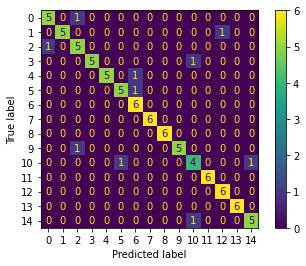

In [19]:
ConfusionMatrixDisplay.from_predictions(y_val, val_preds)

In [20]:
len(y_val)

90